In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
import polyphase as phase
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.figure_factory as ff
%matplotlib notebook

In [4]:
htedf = pd.read_pickle('../data/htev2.pkl')
htedf.head()

,solvent,SM,polymer,chi12,chi13,chi23,dop,delta_solv,delta_SM,delta_polymer
0,Acetone,PC61BM,MDMO-PPV,0.440066,1.478520,1.90338,"[1626.0162601626018, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.62, 5.28]"
1,Acetone,PC61BM,MEH-PPV,0.458907,1.532581,1.90338,"[948.509485094851, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.38, 5.44]"
2,Acetone,PC61BM,P3HT,0.630290,2.719685,1.90338,"[117.82726522917405, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.56, 2.88, 3.19]"
3,Acetone,PC61BM,PFO,0.660927,2.507620,1.90338,"[1200.4944610849618, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.55, 2.8, 4.51]"
4,Acetone,PC61BM,PM6,0.468860,1.896708,1.90338,"[1436.3143631436315, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.37, 4.36, 4.19]"


In [5]:
sys_ds = htedf[(htedf['solvent']=='Toluene')&(htedf['SM']=='DPP(TBFu)2')&(htedf['polymer']=='PFO')]
M = sys_ds['dop'].values[0]
chi = [sys_ds['chi12'].values[0], sys_ds['chi13'].values[0], sys_ds['chi23'].values[0]]
sys_ds

,solvent,SM,polymer,chi12,chi13,chi23,dop,delta_solv,delta_SM,delta_polymer
3543,Toluene,DPP(TBFu)2,PFO,0.664428,0.705938,1.679409,"[831.1115499818967, 7.101313320825517, 1]","[18.0, 1.4, 2.0]","[19.33, 4.78, 6.26]","[18.55, 2.8, 4.51]"


3-dimensional grid generated at 0.07s
Using beta (=1.00E-04) correction for energy landscape
Energy computed at 0.30s
Energy is corrected at 0.30s
Convexhull is computed at 0.33s
Using 1.43E-01 as a threshold for Laplacian of a simplex
Total of 2598 simplices in the convex hull
Simplices are labelled at 3.56s
Labels are lifted at 4.86s
Total 11/2598 coplanar simplices
Computation took 4.87s


<IPython.core.display.Javascript object>


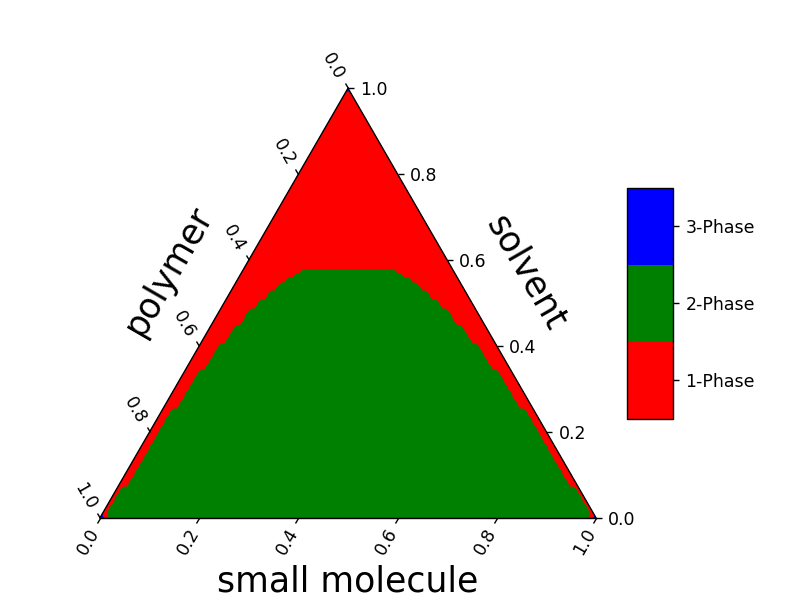

In [6]:
M = [5,5,1]
chi = [1, 0.5, 0.5]
#chi = [1, 0.5, 1]

configuration = {'M':M, 'chi':chi}

meshsize = 100
kwargs = {
    'flag_refine_simplices':True,
    'flag_lift_label': True,
    'use_weighted_delaunay': False,
    'flag_remove_collinear' : False, 
    'beta':1e-4, # not used 
    'flag_make_energy_paraboloid': False, 
    'pad_energy': 2,
    'flag_lift_purecomp_energy': False,
    'threshold_type':'uniform',
    'thresh_scale':0.1*meshsize,
    'lift_grid_size':meshsize,
    'verbose' : True
 }
out = phase.serialcompute(configuration,meshsize, **kwargs) 
grid = out['grid']
num_comps = out['num_comps']
simplices = out['simplices']
energy = out['energy']

phase.plot_lifted_label_ternary(out['output'])
plt.show()

# 1. Visual tests

1. Plot convex hull and energy landscape

In [7]:
MIN_POINT_PRECISION = 1e-8
def is_boundary_point(point):
    if np.isclose(point, MIN_POINT_PRECISION).any():
        return True
    else:
        return False

<IPython.core.display.Javascript object>


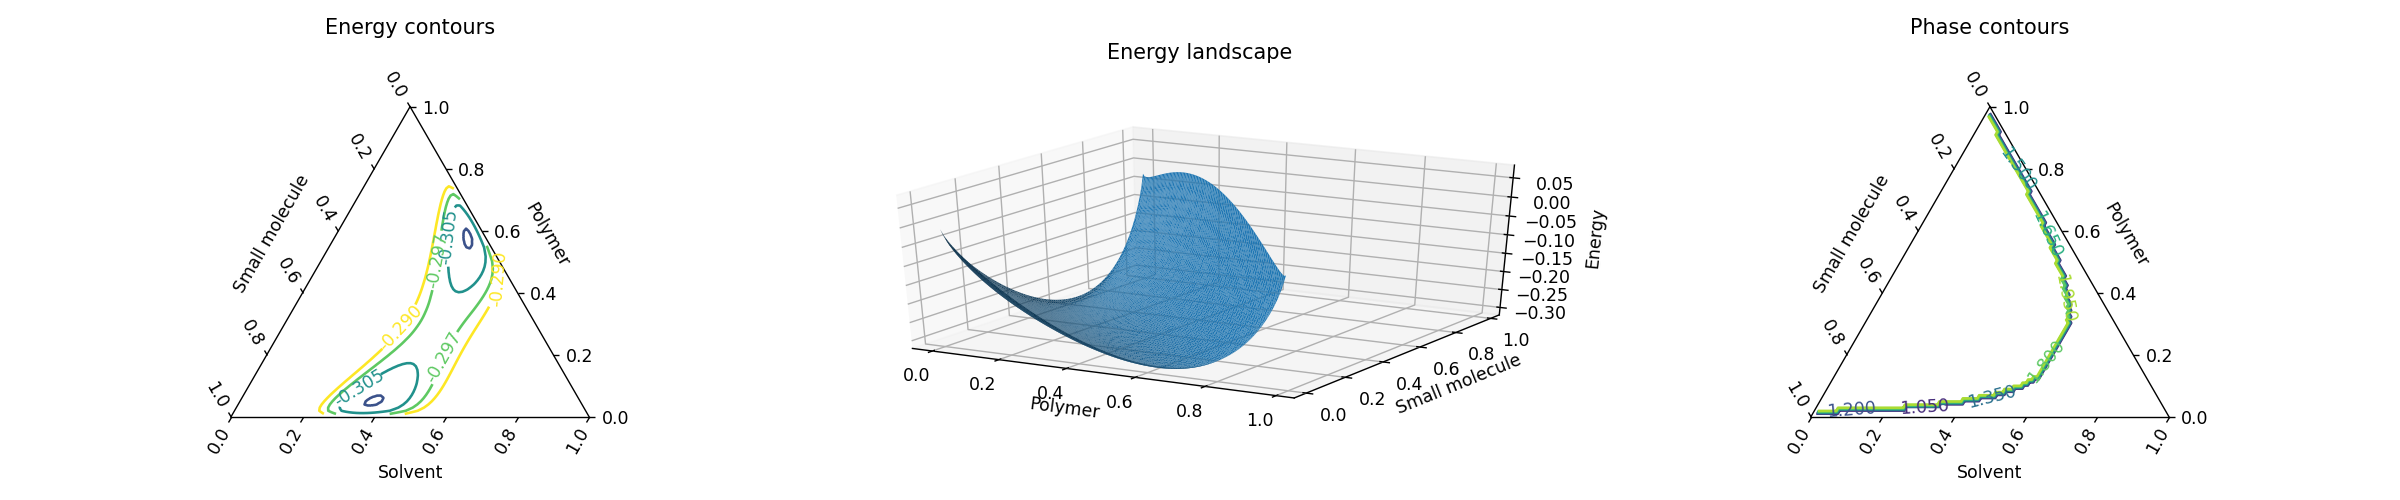

In [8]:
# Mesh size vs Energy surface
def makeAxis(title, tickangle):
    return {
      'title': title,
      'titlefont': { 'size': 20 },
      'tickangle': tickangle,
      'tickfont': { 'size': 15 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

def plotly_ternary_surface(grid, energy, num_comps):
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': "ternary"}, {'is_3d': True}]], 
                    subplot_titles=('Phase diagram','Energy landscape'),
                    print_grid=False)
    
    fig_00 = ff.create_ternary_contour(grid, num_comps,
                                    pole_labels=['polymer', 'SM', 'solvent'],
                                    interp_mode='cartesian',
                                    ncontours=3,
                                    coloring='lines')
    
    for i in fig_00.data:
        fig.append_trace(i, row=1, col=1)
        
    boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
    x, y, z = grid[0,~boundary_points], grid[1,~boundary_points], energy[~boundary_points]
    fig_01 = go.Mesh3d(x=x, y=y, z=z, color='blue')
    fig.append_trace(fig_01,row=1, col=2)
    fig.update_layout(scene1 = dict(xaxis_title='polymer',yaxis_title='SM',zaxis_title='Energy',aspectmode='cube'))

    fig.update_layout(template='plotly_white')
    #fig.update_layout(showlegend=False)
    fig.update_layout({'ternary': {'sum': 100,
                                   'aaxis': makeAxis('Polymer', 0),
                                   'baxis': makeAxis('<br>Small Molecule', 45),
                                   'caxis': makeAxis('<br>Solvent', -45)}
                      })
    fig.layout.annotations[0].update(x=0.025)
    fig.layout.annotations[1].update(x=0.65)
    
    return fig


def plt_ternary_surface(grid, energy, num_comps):
    fig = plt.figure(figsize=(3*4*1.6,4))
    ax1 = fig.add_subplot(1,3,2, projection='3d')
    ax1.plot_trisurf(grid[0,:], grid[1,:], energy, linewidth=0.01, antialiased=True)
    ax1.set_xlabel('Polymer')
    ax1.set_ylabel('Small molecule')
    ax1.set_zlabel('Energy')
    ax1.set_title('Energy landscape', pad=42)
    
    ax2 = fig.add_subplot(1, 3, 1, projection='ternary')
    levels = np.linspace(-0.32, -0.29, 5)
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], energy, levels=levels)
    ax2.set_title("Energy contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    ax2 = fig.add_subplot(1, 3, 3, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], num_comps)
    ax2.set_title("Phase contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    plt.tight_layout()
    return

labels = out['output'].loc['label',:].to_numpy()
boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
plt_ternary_surface(grid[:,~boundary_points], energy[~boundary_points], labels[~boundary_points])
#plt.savefig('../figures/notebooks/{}.png'.format(m), dpi=500, bbox_inches='tight')
plt.show()

# 3. Common tangent test
There's a chance that this would not work because of [sub-derivative of a convex functions](https://en.wikipedia.org/wiki/Subderivative). So not being able to match the local derivatives at any tangent plane is fine because you're working with a discrete surface approximation of the energy landscape.

In [9]:
CHI = phase._utri2mat(configuration['chi'],3)
def threecomp_gradphi(x, beta=0):
    dEdx1 = (1/M[0])*(1+np.log(x[0])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] +\
    CHI[0,2] - 2*CHI[0,2]*x[0] - CHI[0,2]*x[1] - CHI[1,2]*x[1] + beta*((1/x[2]**2) - (1/x[0]**2))
    
    dEdx2 = (1/M[1])*(1+np.log(x[1])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] -\
    CHI[0,2]*x[0] + CHI[1,2] - 2*CHI[1,2]*x[1]  - CHI[1,2]*x[0]+ beta*((1/x[2]**2) - (1/x[1]**2))
    
    return [dEdx1, dEdx2]

[-64.23458378207035, -51.59635989075752, -62.136914779464895]


<IPython.core.display.Javascript object>


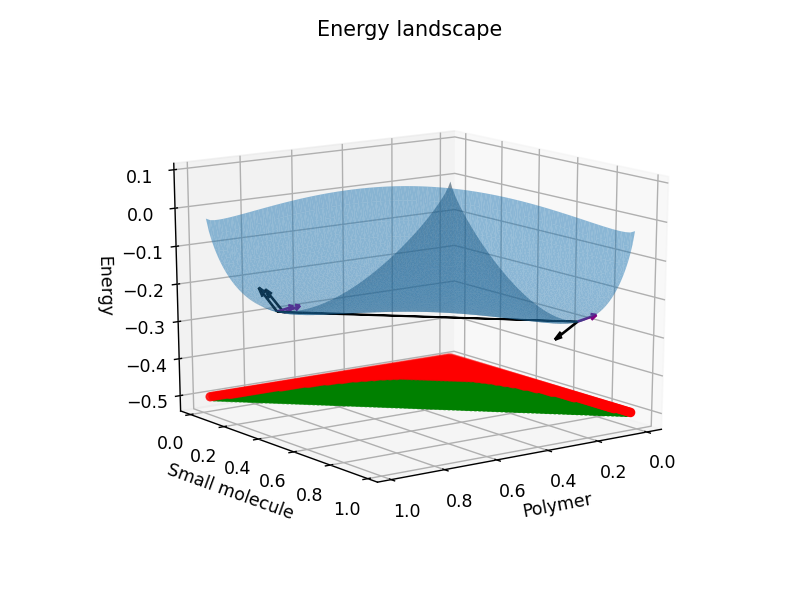

In [11]:
from sympy import Plane, Point3D, Line3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.cm import ScalarMappable
from matplotlib import colors
from collections import Counter
import pdb

class TestAngles:
    def __init__(self, out, phase=2,**kwargs):
        """ Perform a test to compute angles of tangent planes at vertices to convex combination of points
        Test takes the out from polyphase.compute or polyphase.serialcompute and the same kwargs
        """
        self.grid = out['grid']
        self.num_comps = out['num_comps']
        self.simplices = out['simplices']
        self.energy = out['energy']
        self.X = out['output']
        self.phase = phase
        self.beta = kwargs['beta']
        self.__dict__.update(kwargs)
        
    def get_random_simplex(self):
        self.simplices_select_phase = np.asarray(self.simplices)[np.asarray(self.num_comps)==self.phase]
        self.indx = np.random.randint(len(self.simplices_select_phase))
        self.rnd_simplex_indx = self.simplices_select_phase[self.indx]
        self.vertices = self.X.iloc[:3,self.rnd_simplex_indx].to_numpy().T
        self.parametric_points = np.hstack((self.vertices[:,:2],
                                            self.energy[self.rnd_simplex_indx].reshape(-1,1))).tolist()
    
    def get_angles(self,**kwargs):
        self.get_random_simplex()
        self.plane_points = Plane(self.parametric_points[0], self.parametric_points[1],
                             self.parametric_points[2])
        
        thetas = []
        for i, (v,e) in enumerate(zip(self.vertices,
                                      self.energy[self.rnd_simplex_indx])):
            x1,x2,_ = v
            p = Point3D(x1, x2, e)
            dx,dy = threecomp_gradphi(v, beta=self.beta)
            ru = [1,0,dx]
            rv = [0,1,dy]
            uru = ru/np.linalg.norm(ru)
            urv = rv/np.linalg.norm(rv)
            normal_p = np.cross(uru, urv)
            normal_line = Line3D(p, direction_ratio=normal_p)
            thetas.append(np.degrees(float(self.plane_points.angle_between(normal_line))))
            
        return thetas
    
    def simplify_sympy_equation(self, sympyexpr):
        eq_str = []
        for key, value in sympyexpr.as_coefficients_dict().items():
            coeff = float(value)
            varname = str(key)
            if coeff>0:
                eq_str.append('+{:.2E}*{}'.format(coeff, varname))
            else:
                eq_str.append('{:.2E}*{}'.format(coeff, varname))

        return ' '.join(i for i in eq_str)
    
    def visualize(self):
        fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
        boundary_points= np.asarray([is_boundary_point(x) for x in self.grid.T])
        ps = ax.plot_trisurf(self.grid[0,~boundary_points], self.grid[1,~boundary_points], 
                             self.energy[~boundary_points],
                             linewidth=0.01, antialiased=True)
        poly = Poly3DCollection(self.parametric_points,  alpha=1.0, lw=1.0, 
                                facecolors=['tab:red'], edgecolors=['k'])
        ax.add_collection3d(poly)
        labels = self.X.loc['label',:].to_numpy()
        phase_colors =['r','g','b']

        for i, (v,e) in enumerate(zip(self.vertices,energy[self.rnd_simplex_indx])):
            dx,dy = threecomp_gradphi(v,beta=self.beta)
            ru = [1,0,dx]
            rv = [0,1,dy]
            uru = ru/np.linalg.norm(ru)
            urv = rv/np.linalg.norm(rv)
            ax.quiver(v[0], v[1], e, uru[0],uru[1],uru[2], length=0.1, normalize=True, color='k')
            ax.quiver(v[0], v[1], e, urv[0],urv[1],urv[2], length=0.1, normalize=True, color='purple')

        for i in [1,2,3]:
            criteria = np.logical_and(labels==i, ~boundary_points)
            ax.scatter(grid[0,criteria], grid[1,criteria], zs=-0.5, zdir='z',
                       c=phase_colors[int(i-1)])

        ps.set_alpha(0.5)
        ax.set_xlabel('Polymer')
        ax.set_ylabel('Small molecule')
        ax.set_zlabel('Energy')
        ax.set_title('Energy landscape', pad=42)
        ax.view_init(elev=16, azim=54)

        return fig
               
test = TestAngles(out,**kwargs)
print(test.get_angles())
fig = test.visualize()
plt.show()

<IPython.core.display.Javascript object>


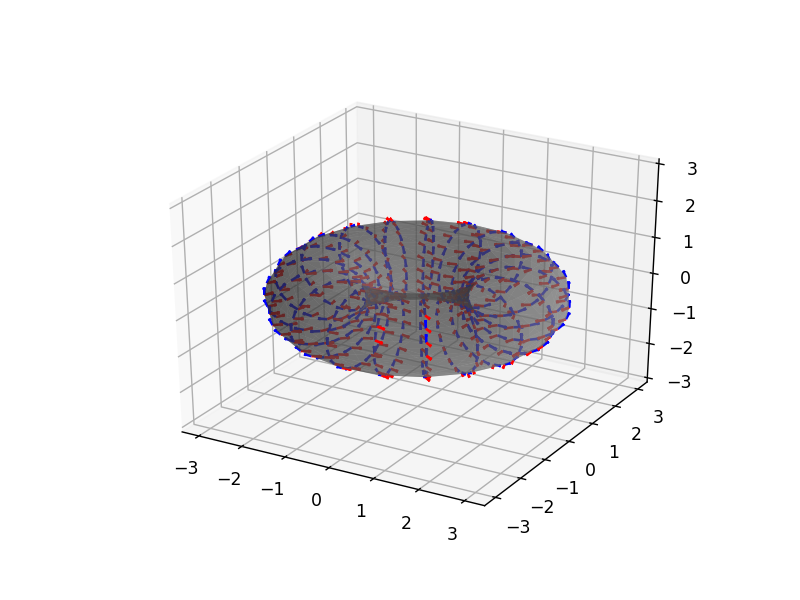

In [10]:
# vector field on a torus
import matplotlib.tri as mtri

n = 20
_theta = np.linspace(0, 2.*np.pi, n)
_phi = np.linspace(0, 2.*np.pi, n)
_theta, _phi = np.meshgrid(_theta, _phi)
positions = np.vstack([_theta.ravel(), _phi.ravel()]).T
c, a = 2, 1

def get_trous_pointcloud(theta, phi):
    x = (c + a*np.cos(theta)) * np.cos(phi)
    y = (c + a*np.cos(theta)) * np.sin(phi)
    z = a * np.sin(theta)
    
    return [x,y,z]

def get_trous_gradients(theta, phi):

    rtheta = [-a*np.cos(phi)*np.sin(theta), -a*np.sin(phi)*np.sin(theta), a*np.cos(theta)]
    rphi = [-np.sin(phi)*(c + a*np.cos(theta)), -np.cos(phi)*(c + a*np.cos(theta)), 0]

    uv_rtheta = rtheta/np.linalg.norm(rtheta)
    uv_rphi = rphi/np.linalg.norm(rphi)
    
    return uv_rtheta, uv_rphi

tri = mtri.Triangulation(positions[:,0], positions[:,1])
T = np.asarray([get_trous_pointcloud(u,v) for u,v in positions])
#Ru, Rv = np.asarray([get_trous_gradients(u,v) for u,v in positions])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(T[:,0], T[:,1], T[:,2],triangles=tri.triangles,linewidth=0.01, color='gray', alpha=0.5)

for i in range(0, len(positions),1):
    x,y,z = T[i,:]
    RU, RV = get_trous_gradients(positions[i,0], positions[i,1])
    ax.quiver(x,y,z, RU[0], RU[1], RU[2],length=0.2, normalize=True, color='b' )
    ax.quiver(x,y,z, RV[0], RV[1], RV[2],length=0.2, normalize=True, color='r' )

ax.set_zlim([-3,3])
plt.show()